In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from tqdm import tqdm
from matplotlib import pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
import st_toolkit as geohl
import cri_calc as cri
import cri_helper as helper

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from joblib import Parallel, delayed

In [4]:
import shap
shap.initjs()

# Loading Training Dataset 

In [5]:
gdf_vcra = pd.read_pickle('./data/norway-dataset/oslo_jan_mar_2019_4w_prep_encountering.vcra_dataset_v14.pickle').dropna()

gdf_vcra.loc[:, 'ves_cri_bin'] = pd.cut(gdf_vcra.ves_cri, bins=np.arange(0, 1.1, .2), right=True, include_lowest=True)

In [6]:
def vcra_model_explainability(model, scaler, X_train, X_test, y_train, y_test, y_bin_train, y_bin_test, n_samples_per_bin=None, shap_n_clusters=10):    
    # Get a dis-proportionate subset of the dataset 
    n_samples_per_bin = y_bin_test.value_counts().min() if n_samples_per_bin is None else n_samples_per_bin
    print(f'{n_samples_per_bin} samples per "class"; ~{n_samples_per_bin*10} testing samples per "class"')
    
    # Fetch ```n_samples_per_bin``` random samples per ```y_bin_test```
    indices = pd.DataFrame(
        np.hstack((X_test, y_test.reshape(-1, 1)))
    ).groupby(y_bin_test, group_keys=False).apply(lambda l: l.sample(n_samples_per_bin) if n_samples_per_bin < len(l) else l).index
    
    X_test_sample, y_test_sample = X_test[indices], y_test[indices]
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test_sample)

    # Calculate SHAP Values
    X_train_summary = shap.kmeans(X_train_scaled, shap_n_clusters)
    
    # explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
    explainer = shap.KernelExplainer(model.predict, X_train_summary)

    shap_values = explainer.shap_values(X_test_scaled)
    return explainer, shap_values, X_test_scaled

# Assessing the Explainability of MLP-VCRA using SHAP Values 

In [7]:
# Load models from Stratified k-Fold Cross Validation
skf_results_df = pd.read_pickle('./data/pickle/mlp_vcra_skf_results_v14.trained_on_all_data.w_indices.pickle')

# Get the Best Performing Model out of all Folds
mlp_vcra = skf_results_df.loc[skf_results_df.rmsle.idxmin()].copy()

## Calculating SHAP Values for MLP-VCRA

In [8]:
# mlp_vcra_features = ['own_speed', 'own_course', 'target_speed', 'target_course', 'dist_euclid', 'azimuth_angle_target_to_own', 'rel_movement_direction']
mlp_vcra_features = ['own_speed', 'own_course_rad', 'target_speed', 'target_course_rad', 'dist_euclid', 'azimuth_angle_target_to_own', 'rel_movement_direction']

In [9]:
# Get Train/Test Sets
X_train, X_test = mlp_vcra.X_train, mlp_vcra.X_test
y_train, y_test = mlp_vcra.y_train, mlp_vcra.y_true

y_bin_train, y_bin_test = pd.cut(y_train, bins=np.arange(0, 1.1, .2), right=True, include_lowest=True),\
                          pd.cut(y_test, bins=np.arange(0, 1.1, .2), right=True, include_lowest=True)

In [10]:
mlp_vcra_pipeline = mlp_vcra.instance
mlp_vcra_pipeline.steps

[('standardscaler', StandardScaler()),
 ('mlpregressor',
  MLPRegressor(early_stopping=True, hidden_layer_sizes=(256, 32), max_iter=100,
               random_state=10, verbose=True))]

### WAIT, we need the optimal **k** for the shap_n_clusters... 
#### ...so far, let's run along with the number of distinct bins (i.e., 10 clusters)

In [11]:
model, scaler = mlp_vcra_pipeline['mlpregressor'], mlp_vcra_pipeline['standardscaler']

In [13]:
explainer, shap_values, X_test_scaled = vcra_model_explainability(
    model, scaler, 
    X_train, X_test, y_train, y_test, y_bin_train, y_bin_test, 
    shap_n_clusters=10,
    n_samples_per_bin=10000,
)

10000 samples per "class"; ~100000 testing samples per "class"


  0%|          | 0/22941 [00:00<?, ?it/s]

In [14]:
mlp_vcra_features

['own_speed',
 'own_course_rad',
 'target_speed',
 'target_course_rad',
 'dist_euclid',
 'azimuth_angle_target_to_own',
 'rel_movement_direction']

In [15]:
scaler.mean_, scaler.var_

(array([9.36936313, 3.53727289, 4.10956132, 2.63994849, 0.51801707,
        3.35386354, 3.41772678]),
 array([22.36693529,  3.5522013 , 38.05696416,  4.01813453,  0.05237976,
         2.9479129 ,  3.39520899]))

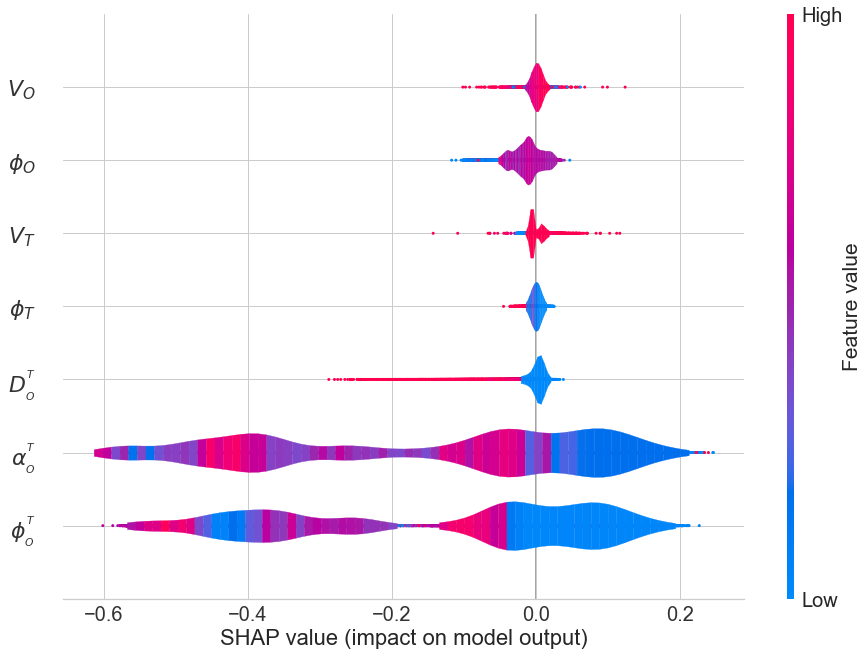

In [27]:
shap.summary_plot(
    shap_values, X_test_scaled, sort=False, plot_type='violin',
    feature_names=mlp_vcra_features, plot_size=(15, 9),
    show=False, layered_violin_max_num_bins=10
)
fig, ax = plt.gcf(), plt.gca()

ax.set_yticklabels([r'$V_O$', r'$\phi_O$', r'$V_T$', r'$\phi_T$', r'$D_{_O}^{^T}$', r'$\alpha_{_O}^{^T}$', r'$\phi_{_O}^{^T}$'][::-1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + [fig.axes[-1].yaxis.label] + fig.axes[-1].get_yticklabels()):
    item.set_fontsize(item.get_fontsize() + 9)

plt.savefig('shap_summary_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

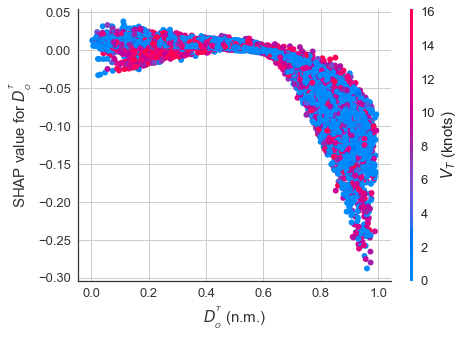

In [16]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))

# 4 : Distance vs. Target Speed
shap.dependence_plot(
    4, shap_values, scaler.inverse_transform(X_test_scaled),
    feature_names=mlp_vcra_features, dot_size=35,
    ax=ax, show=False
)

ax.set_xlabel(r'$D_{_O}^{^T}$ (n.m.)')
ax.set_ylabel(r'SHAP value for $D_{_O}^{^T}$')

fig.axes[-1].set_ylabel(r'$V_T$ (knots)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + [fig.axes[-1].yaxis.label] + fig.axes[-1].get_yticklabels()):
    item.set_fontsize(item.get_fontsize() + 2)

plt.savefig('shap_dependence__dot_vs_vt.pdf', dpi=300, bbox_inches='tight')

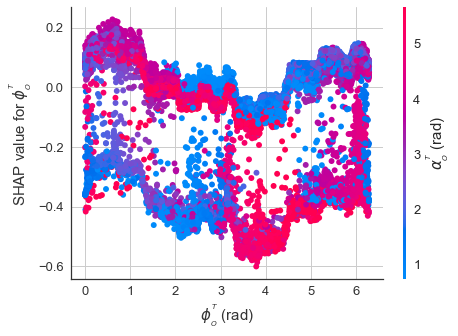

In [17]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))

# 6 : phi vs. alpha
shap.dependence_plot(
    6, shap_values, scaler.inverse_transform(X_test_scaled),
    feature_names=mlp_vcra_features, dot_size=35,
    ax=ax, show=False
)

ax.set_xlabel(r'$\phi_{_O}^{^T}$ (rad)')
ax.set_ylabel(r'SHAP value for $\phi_{_O}^{^T}$')

fig.axes[-1].set_ylabel(r'$\alpha_{_O}^{^T}$ (rad)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + [fig.axes[-1].yaxis.label] + fig.axes[-1].get_yticklabels()):
    item.set_fontsize(item.get_fontsize() + 2)

plt.savefig('shap_dependence__phiot_vs_alphaot.pdf', dpi=300, bbox_inches='tight')